In [48]:
import pandas as pd
import numpy as np
import csv as csv
import os
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

time: 4.85 ms


In [16]:
# %install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.13 ms


In [13]:
# Data cleanup
# TRAIN DATA
os.chdir(os.path.expanduser("~/Dropbox/Projects/data/kaggle/renthop/"))
train = pd.read_json('train.json', convert_dates=['created'])        # Load the train file into a dataframe
test = pd.read_json('test.json', convert_dates=['created'])
train.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in the apt? Cable Internet Ready? Granite Counter Top Kitchen w/ lot of cabinet storage spaceIt's Just A Few blocks To L Train<br /><br />Don't miss out!<br /><br />We have several great apartments in the immediate area.<br /><br />For additional information 687-878-2229<p><a website_redacted,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,"[https://photos.renthop.com/2/7211212_1ed4542ec81621d70d1061aa833e669c.jpg, https://photos.renthop.com/2/7211212_7dfc41dced69245065df83d08eed4a00.jpg, https://photos.renthop.com/2/7211212_c17853c4b869af6f53af08b0f5820b4c.jpg, https://photos.renthop.com/2/7211212_787ad8ea0c089792e7453e2121f8ac89.jpg, https://photos.renthop.com/2/7211212_2e88b0d293ee333c804c2f00536eee49.jpg]",3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allowed, Dogs Allowed]",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,"[https://photos.renthop.com/2/7150865_be3306c5d89c6bfa755c6e89c9ed64d5.jpg, https://photos.renthop.com/2/7150865_655f861a1d5da70050010611016ae2ad.jpg, https://photos.renthop.com/2/7150865_5b8cc459f3abd38bc81cbf329dab3220.jpg, https://photos.renthop.com/2/7150865_2f59c34ca4ea98c26d559109a467ef84.jpg, https://photos.renthop.com/2/7150865_2258d2eb5b5fb4bc0eb6534929cdee15.jpg, https://photos.renthop.com/2/7150865_af28a5075bd321e694791645423dcdde.jpg, https://photos.renthop.com/2/7150865_714a3d63488162ebe4a22896dd5138f7.jpg, https://photos.renthop.com/2/7150865_8dda0ecbe4c6015d3e8dffe16808aa0b.jpg, https://photos.renthop.com/2/7150865_c4aabf346e295afda87d13c16f6f5659.jpg, https://photos.renthop.com/2/7150865_2de68908ea943dd96c925490c7f98297.jpg, https://photos.renthop.com/2/7150865_fc18c2e84683b567c9568ed7597f1ba8.jpg]",5465,808 Columbus Avenue


In [14]:
train.dtypes

bathrooms          float64       
bedrooms           int64         
building_id        object        
created            datetime64[ns]
description        object        
display_address    object        
features           object        
interest_level     object        
latitude           float64       
listing_id         int64         
longitude          float64       
manager_id         object        
photos             object        
price              int64         
street_address     object        
dtype: object

## String features

In [20]:
train.description.head(2)

10       A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in the apt? Cable Internet Ready? Granite Counter Top Kitchen w/ lot of cabinet storage spaceIt's Just A Few blocks To L Train<br /><br />Don't miss out!<br /><br />We have several great apartments in the immediate area.<br /><br />For additional information 687-878-2229<p><a  website_redacted 
10000                                                                                                                                                                                                                                                                                                                                                                                                             

time: 3.36 ms


In [30]:
# count of paragraphs for clarity of formating
train['br_count'] = train.description.str.count('<br />')

time: 101 ms


In [40]:
train['description_length'] = train.description.str.len()
# train['feature_length'] = train.description.str.len()

time: 15.9 ms


In [33]:
train.features.head()

10        []                                                                           
10000     [Doorman, Elevator, Fitness Center, Cats Allowed, Dogs Allowed]              
100004    [Laundry In Building, Dishwasher, Hardwood Floors, Pets Allowed Case by Case]
100007    [Hardwood Floors, No Fee]                                                    
100013    [Pre-War]                                                                    
Name: features, dtype: object

time: 4.04 ms


In [38]:
train['feature_count'] = train.features.str.len()

train['photo_count'] = train.photos.str.len()

time: 20.2 ms


In [43]:
feature_list = list(set(train.features.apply(pd.Series).stack().tolist()))

time: 10.1 s


In [46]:
print len(feature_list)
feature_list

1556


[u'Updated Kitchen and Bathroom',
 u'Gym Fitness Lounge Swimming Pool Sun Decks Exercise Studios Indoor Half-Basketball Court',
 u'Gas&Electric included',
 u'private-outdoor-space',
 u'Great Natural Light',
 u'Super On Site',
 u'Vaulted Ceilings',
 u'custom lighting',
 u'Diswasher',
 u'Brand Newm Outdoor Deck',
 u'STAINLESS STEEL',
 u'central air',
 u'Central Park 1/2 block away!',
 u'** HOLY DEAL BATMAN! * ENTIRE FLOOR! * MASSIVE 4BR MANSION * GOURMET KITCHEN * PETS OK **',
 u'** PRISTINE PREWAR GEM! * MASSIVE 3BR SUPER SHARE * GUT RENOVATED * CHEF;S KITCHEN * ELEV BLDG * PETS OK **',
 u'2nd Ave',
 u'Sun Drenched',
 u'Pets: Case by case',
 u'fireplace',
 u'must see',
 u'** PRISTINE PARK AVE S LOFT! * MASSIVE 3BR MANSION * WALLS OF WINDOWS * CHEF INSPIRED KITCHEN * ELEV BLDG **',
 u'Sun deck',
 u'Doorman',
 u'laundry in building',
 u'amazing detail',
 u'New Renovation',
 u'Pets Allowed Case by Case',
 u'King-Sized Bedroom',
 u'EXPOSED BRICK',
 u'on-sites super',
 u'Laundry in Some Unit

time: 37.7 ms


In [57]:
p_no = re.compile('(^| )no( |$)')
feature_no = [f for f in feature_list if p_no.search(f.lower())]
feature_no

[u'** REAL NO FEE! * MASSIVE TRUE 2BR SUPER SHARE * ALL MODERN & NEW * EAT-IN KITCHEN * 2 BLKS TO THE TRAIN **',
 u'** NO FEE BABY! * MASSIVE 2BR w/TERRACE * GOURMET SS KITCHEN * ELEV/LNDRY BLDG * SCENIC ROOF DECK * 3 BLKS TO TRAIN **',
 u'NO FEE!!!Roof Deck',
 u'** ELEGANT E50s & PARK BABY! * MASSIVE 4BR MANSION * NO BROKER FEE * DISHWASHER * WALLS OF WINDOWS * ELEV BLDG **',
 u"** OVERSIZED & UNDERPRICED NO FEE * SPRAWLING 3BR SUPER SHARE * SEPARATE COOK'S KITCHEN * WALLS OF WINDOWS * 2 BLKS TO TRAIN **",
 u'Sorry no pets',
 u'No Pets',
 u'** SUPER SWEET STUDIO * NO FEE * DISHWASHER * ROOMY CLOSETS * ELEV BLDG * PETS OK **',
 u'No Fee!!!',
 u'** HOLY NO FEE! * OVERSIZED 2BR HOME * PRIVATE TERRACE & SCENIC ROOF DECK * SS KITCHEN * DISHWASHER * ELEV/LNDRY BLDG * 3 BLKS TO L TRAIN **',
 u'No Fee or One Month Free',
 u'** NO FEE BKLN LUXURY! * EXPANSIVE 1BR w/HOME OFFICE * EAT-IN KITCHEN * FULL RENOVATED * 1 BLK TO THE PARK * STEPS TO L TRAIN **',
 u'** RIVERSIDE NO FEE SPECIAL! * SPRAWL

time: 8.96 ms


### to do:
- create no fee feature
- count of !
- percentage capital letters
- read the column as object and split on '(,| * | - )'
- word count

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1525a0bd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14d50fa90>]], dtype=object)

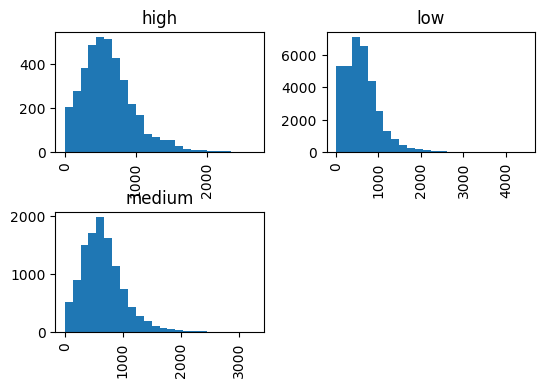

time: 622 ms


In [78]:
train['description_length'].hist(by=train['interest_level'], bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x146725050>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1442d1650>]], dtype=object)

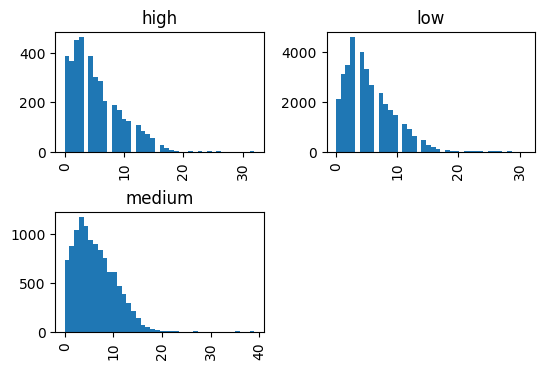

time: 733 ms


In [80]:
train['feature_count'].hist(by=train['interest_level'], bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1730bcb50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14ff43a50>]], dtype=object)

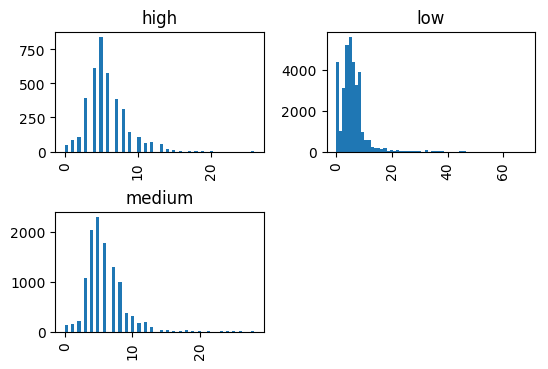

time: 884 ms


In [82]:
train['photo_count'].hist(by=train['interest_level'], bins=60)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1508bd050>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15759b0d0>]], dtype=object)

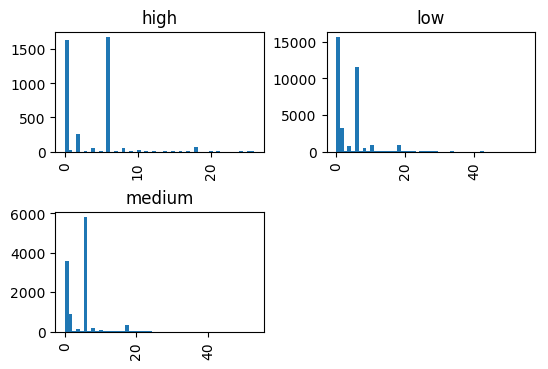

time: 850 ms


In [84]:
train['br_count'].hist(by=train['interest_level'], bins=50)

## Datetime features

In [61]:
train.created.head()

10       2016-06-24 07:54:24
10000    2016-06-12 12:19:27
100004   2016-04-17 03:26:41
100007   2016-04-18 02:22:02
100013   2016-04-28 01:32:41
Name: created, dtype: datetime64[ns]

time: 3.39 ms


In [70]:
train['dayofweek'] = train.created.dt.dayofweek
train['day'] = train.created.dt.day
train['hour'] = train.created.dt.hour

time: 13.6 ms


In [66]:
train.created.dt.hour.value_counts().sort_index()

0     55   
1     5749 
2     10596
3     8318 
4     5021 
5     7954 
6     4446 
7     1047 
8     336  
9     135  
10    284  
11    444  
12    693  
13    616  
14    782  
15    753  
16    370  
17    443  
18    450  
19    266  
20    191  
21    178  
22    139  
23    86   
Name: created, dtype: int64

time: 6.68 ms


In [67]:
train.created.dt.month.value_counts().sort_index()

4    16411
5    15797
6    17144
Name: created, dtype: int64

time: 6.08 ms


In [68]:
train.created.dt.day.value_counts().sort_index()

1     894 
2     1783
3     1803
4     1493
5     1808
6     1851
7     1764
8     1655
9     1514
10    1603
11    1702
12    2348
13    1736
14    1951
15    1701
16    1891
17    1615
18    1483
19    1412
20    1762
21    2475
22    1669
23    1049
24    1862
25    1458
26    1470
27    1588
28    1644
29    1641
30    721 
31    6   
Name: created, dtype: int64

time: 7.57 ms


In [69]:
train.created.dt.dayofweek.value_counts().sort_index()

0    4239
1    8417
2    9414
3    8195
4    7593
5    6953
6    4541
Name: created, dtype: int64

time: 6.66 ms


In [71]:
train.created.dt.weekday.value_counts().sort_index()

0    4239
1    8417
2    9414
3    8195
4    7593
5    6953
6    4541
Name: created, dtype: int64

time: 6.95 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14f2348d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14f879110>]], dtype=object)

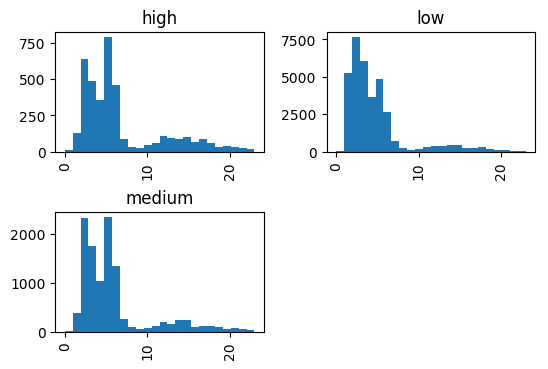

time: 620 ms


In [73]:
train['hour'].hist(by=train['interest_level'], bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x171fa3450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x17222c850>]], dtype=object)

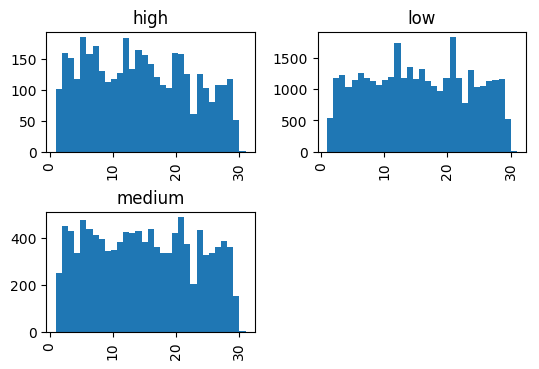

time: 691 ms


In [75]:
train['day'].hist(by=train['interest_level'], bins=31)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x145fe0850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1488c2550>]], dtype=object)

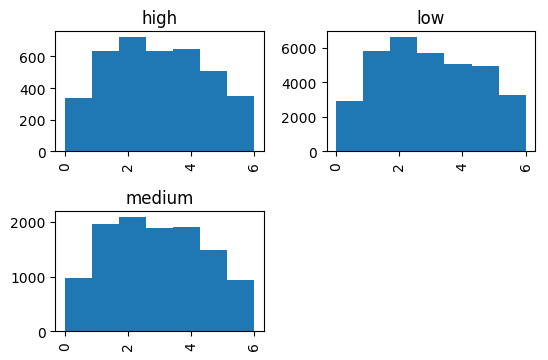

time: 504 ms


In [77]:
train['dayofweek'].hist(by=train['interest_level'], bins=7)

In [18]:
con_all = train.select_dtypes(include=['float64', 'int64']).columns.values
outcome = np.array(['id'])
con = np.setdiff1d(con_all, outcome)
con

array([u'bathrooms', u'bedrooms', u'latitude', u'listing_id', u'longitude',
       u'price'], dtype=object)

time: 6.33 ms


In [17]:
train.count()

bathrooms          49352
bedrooms           49352
building_id        49352
created            49352
description        49352
display_address    49352
features           49352
interest_level     49352
latitude           49352
listing_id         49352
longitude          49352
manager_id         49352
photos             49352
price              49352
street_address     49352
dtype: int64

time: 37.4 ms


In [7]:
cat_all = train.select_dtypes(include=['object']).columns.values
outcome = np.array(['type'])
cat = np.setdiff1d(cat_all, outcome)
cat

array([u'building_id', u'created', u'description', u'display_address',
       u'features', u'interest_level', u'manager_id', u'photos',
       u'street_address'], dtype=object)

In [8]:
train.color.value_counts()

AttributeError: 'DataFrame' object has no attribute 'color'

In [7]:
le = LabelEncoder()
for v in cat:
    le.fit(train[v].append(test[v], ignore_index=True))
#     print list(le.classes_)
    train[v] = le.transform(train[v])
    test[v] = le.transform(test[v])

In [8]:
enc = OneHotEncoder()

enc.fit(train[cat].append(test[cat], ignore_index=True))
train_cat = enc.transform(train[cat]).toarray()
test_cat = enc.transform(test[cat]).toarray()

In [9]:
train_con = train[con]
test_con = test[con]

In [10]:
X_train = np.concatenate((train_cat, train_con), axis=1)
X_test = np.concatenate((test_cat, test_con), axis=1)

In [11]:
Y_train = train.type

le.fit(Y_train)
Y_train = le.transform(Y_train)
print list(le.classes_)
Y_train

['Ghost', 'Ghoul', 'Goblin']


array([1, 2, 1, 1, 0, 2, 2, 1, 0, 0, 2, 1, 1, 2, 2, 1, 0, 1, 1, 0, 2, 1, 2,
       1, 1, 0, 2, 2, 2, 2, 1, 0, 2, 2, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 2,
       1, 0, 2, 2, 1, 1, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 2, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 2, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 1, 2, 1, 1, 0, 1,
       2, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 1, 0, 2, 1, 0, 2,
       0, 0, 2, 0, 1, 2, 2, 0, 2, 1, 0, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2,
       2, 1, 2, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 0,
       2, 2, 1, 2, 2, 1, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 1, 0,
       2, 2, 0, 0, 0, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 0, 1, 1, 1, 2, 0, 0, 1,
       2, 2, 2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 1, 0, 2, 2, 1, 2, 1, 1, 2, 0, 1,
       1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1,
       2, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 1, 1, 2,
       0, 0, 2, 1, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 2,
       0, 0,

In [10]:
train.type.value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

In [23]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
output = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X_train, Y_train).predict(X_test)
# output

outdf = pd.DataFrame()
outdf['id'] = test['id']
outdf['type'] = le.inverse_transform(output)
outdf.to_csv('submissions/onevstherest_linearsvc.csv', index=False)
print 'Done.'

Done.


In [25]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
output = OneVsRestClassifier(SVC(kernel='linear')).fit(X_train, Y_train).predict(X_test)
# output

outdf = pd.DataFrame()
outdf['id'] = test['id']
outdf['type'] = le.inverse_transform(output)
outdf.to_csv('submissions/onevstherest_svc.csv', index=False)
print 'Done.'

Done.


In [26]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

output = OneVsRestClassifier(RandomForestClassifier(n_estimators=100)).fit(X_train, Y_train).predict(X_test)
# output

outdf = pd.DataFrame()
outdf['id'] = test['id']
outdf['type'] = le.inverse_transform(output)
outdf.to_csv('submissions/onevstherest_rf.csv', index=False)
print 'Done.'

Done.


In [27]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier

output = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100)).fit(X_train, Y_train).predict(X_test)
# output

outdf = pd.DataFrame()
outdf['id'] = test['id']
outdf['type'] = le.inverse_transform(output)
outdf.to_csv('submissions/onevstherest_gbm.csv', index=False)
print 'Done.'

Done.


In [22]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
output = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X_train, Y_train).predict(X_test)
# output

outdf = pd.DataFrame()
outdf['id'] = test['id']
outdf['type'] = le.inverse_transform(output)
outdf.to_csv('submissions/onevsone_linearsvc.csv', index=False)
print 'Done.'

Done.
